<a href="https://colab.research.google.com/github/gongqihang/PyNLO/blob/master/SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pynlo

    100% |████████████████████████████████| 61kB 4.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/af/18/c4/ef63d13ba6d03e11a31461de3a88ed7d65191cc602bb8cc589
Successfully built pynlo


Pulse energy before Simple Fiber : 0.05000000000000001 nJ
pulse energy in  2168.8948070049655
copied as   2168.8948070049655
Step: 0 Distance remaining: 0.02
Pulse energy after: 0.04891448568582959 nJ
Step: 1 Distance remaining: 0.0198
Pulse energy after: 0.04889521530938287 nJ
Step: 2 Distance remaining: 0.0196
Pulse energy after: 0.04886888030175812 nJ
Step: 3 Distance remaining: 0.0194
Pulse energy after: 0.04883531581570155 nJ
Step: 4 Distance remaining: 0.0192
Pulse energy after: 0.048794347991293965 nJ
Step: 5 Distance remaining: 0.019
Pulse energy after: 0.04874590507130589 nJ
Step: 6 Distance remaining: 0.0188
Pulse energy after: 0.0486901846864406 nJ
Step: 7 Distance remaining: 0.0186
Pulse energy after: 0.04862790437726602 nJ
Step: 8 Distance remaining: 0.0184
Pulse energy after: 0.04856066549720941 nJ
Step: 9 Distance remaining: 0.0182
Pulse energy after: 0.04849145222698155 nJ
Step: 10 Distance remaining: 0.018
Pulse energy after: 0.048425256401292624 nJ
Step: 11 Distance r

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10


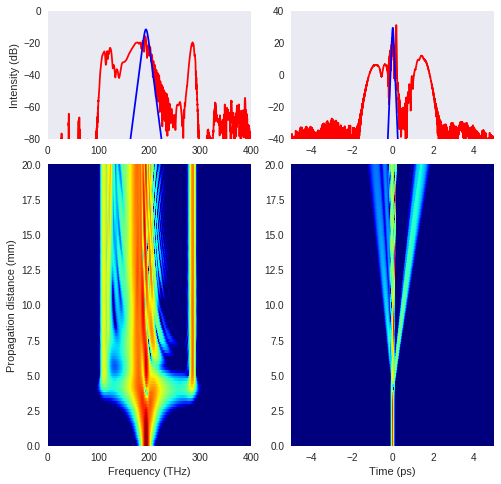

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

FWHM    = 0.050  # pulse duration (ps)
pulseWL = 1550   # pulse central wavelength (nm)
EPP     = 50e-12 # Energy per pulse (J)
GDD     = 0.0    # Group delay dispersion (ps^2)
TOD     = 0.0    # Third order dispersion (ps^3)

Window  = 10.0   # simulation window (ps)
Steps   = 100     # simulation steps
Points  = 2**13  # simulation points

beta2   = -120     # (ps^2/km)
beta3   = 0.00     # (ps^3/km)
beta4   = 0.005    # (ps^4/km)

Length  = 20    # length in mm

Alpha   = 0.0     # attentuation coefficient (dB/cm)
Gamma   = 1000    # Gamma (1/(W km)

fibWL   = pulseWL # Center WL of fiber (nm)

Raman   = True    # Enable Raman effect?
Steep   = True    # Enable self steepening?

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# set up plots for the results:
fig = plt.figure(figsize=(8,8))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.SechPulse(power = 1, # Power will be scaled by set_epp
                                            T0_ps                   = FWHM/1.76,
                                            center_wavelength_nm    = pulseWL,
                                            time_window_ps          = Window,
                                            GDD=GDD, TOD=TOD,
                                            NPTS            = Points,
                                            frep_MHz        = 100,
                                            power_is_avg    = False)
# set the pulse energy!
pulse.set_epp(EPP)

# create the fiber!
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.005, USE_SIMPLE_RAMAN=True,
                 disable_Raman              = np.logical_not(Raman),
                 disable_self_steepening    = np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)

########## That's it! Physics complete. Just plotting commands from here! ################


F = pulse.F_THz     # Frequency grid of pulse (THz)

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y_mm = y * 1e3 # convert distance to mm



ax0.plot(pulse_out.F_THz,    dB(pulse_out.AW),  color = 'r')
ax1.plot(pulse_out.T_ps,     dB(pulse_out.AT),  color = 'r')

ax0.plot(pulse.F_THz,    dB(pulse.AW),  color = 'b')
ax1.plot(pulse.T_ps,     dB(pulse.AT),  color = 'b')

extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, cmap='jet', extent=extent,
           vmin=np.max(zW) - 40.0, vmax=np.max(zW),
           aspect='auto', origin='lower')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), Length)
ax3.imshow(zT, cmap='jet', extent=extent,
           vmin=np.max(zT) - 40.0, vmax=np.max(zT),
           aspect='auto', origin='lower')


ax0.set_ylabel('Intensity (dB)')
ax0.set_ylim( - 80,  0)
ax1.set_ylim( - 40, 40)

ax2.set_ylabel('Propagation distance (mm)')
ax2.set_xlabel('Frequency (THz)')
ax2.set_xlim(0,400)

ax3.set_xlabel('Time (ps)')

ax0.grid(b=None)
ax1.grid(b=None)
ax2.grid(b=None)
ax3.grid(b=None)

plt.show()
